In [1]:
#####################################################################
# This notebook is authored by: Lina Alasfar                        #
# Date: May 2022                                                    #
# If you use this code or the results from this work please cite:   # 
# Machine learning the trilinear and light-quark Yukawa couplings   #
# from Higgs pair kinematic shapes                                  #
# Lina Alasfar, Ramona Gröber, Christophe Grojean, Ayan Paul        #
# and Zuoni Qian                                                    #
# arXiv:2205.XXXXX (https://arxiv.org/abs/2005.XXXXX)               # 
#####################################################################

import numpy as np
import pyhf
import yaml
from pyik.numpyext import rebin
import warnings
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
from scipy.interpolate import interp1d
import matplotlib as mtlp
from pyik.mplext import plot_hist
from scipy.stats import norm, poisson,chi2
from scipy.interpolate import splev, splrep
from scipy.interpolate import griddata
from pyik.numpyext import rebin
import mplhep as hep
from matplotlib.ticker import AutoMinorLocator
from matplotlib import rc
from sigma_br_HL_LHC import *
rc('text', usetex=True)
warnings.filterwarnings("ignore")
pyhf.set_backend('numpy')
filename ="./data.yaml"
stream = open(filename, 'r')
 
data= yaml.safe_load(stream)
col= ['#9a9db6','#c5abbd','#b399c0','#b399c0','#90d0db','#afd3eb']
import json


In [2]:
with open('../results/confusion/HL-LHC-BDT/hh-BDT-5class-hhsm.confusion.json') as f:
    confusion_l = json.load(f)
    
with open('../results/confusion/HL-LHC-BDT/hh-BDT-6class-kd.confusion.json') as f:
    confusion_d = json.load(f)
    
with open('../results/confusion/HL-LHC-BDT/hh-BDT-6class-ku.confusion.json') as f:
    confusion_u = json.load(f)
    
with open('../results/confusion/HL-LHC-BDT/hh-BDT-5class-ku-kd.confusion.json') as f:
    confusion_ud = json.load(f)

In [3]:
## Some functions 
#
LambdaNP = 1e+3  #GeV
v = 246.
mh = 125.1
mass = {
'ku':2.2e-3,
'kd':4.7e-3,
'ks':95e-3,
'kc':1.275,
}

def kqtoCqH(kq,op):
    if op=='ku'or op=='kd'or op=='ks' or  op=='kc':
        return LambdaNP**2/v**3*(np.sqrt(2.0)*mass[op]*(1-kq))
    else:
        return kq

def CqHtokq(CqH,op):
    if op=='ku'or op=='kd'or op=='ks' or  op=='kc':
        return -(CqH/np.sqrt(2)/LambdaNP**2 *v**3/mass[op])+1
    else:
        return CqH
def CHtokl(CH):
    return 1-2.0*CH*v**4/mh**2/LambdaNP**2

def kltoCH(kl):
    return LambdaNP**2/v**4*mh**2*0.5*(1-kl)
######################################################################


In [4]:

def CLs(CqH,CH,op):
    if op=='kukl':
        kq=CqHtokq(CqH,'ku')
        kl=CHtokl(CH)
        bkgkd=sigmahh_kukl(1., 1., 'ku', confusion_u)
        sigkd = sigmahh_kukl(kq, kl, 'ku', confusion_u)-bkgkd
    #
        bkgtri=sigmahh_kukl(1., 1., 'tri', confusion_u)
        sigtri = sigmahh_kukl(kq, kl, 'tri', confusion_u)-bkgtri
    #
        bkgint=sigmahh_kukl(1., 1., 'int', confusion_u)
        sigint = sigmahh_kukl(kq, kl, 'int', confusion_u)-bkgint
        signal_d= [ \
             sigkd,\
             sigtri,sigint]
        bkg_d= [\
             bkgkd,\
             bkgtri,bkgint]
    elif op=='kdkl':
        kq=CqHtokq(CqH,'kd')
        kl=CHtokl(CH)
        bkgkd=sigmahh_kdkl(1., 1., 'kd', confusion_d)
        sigkd = sigmahh_kdkl(kq, kl, 'kd', confusion_d)-bkgkd
    #
        bkgtri=sigmahh_kdkl(1., 1., 'tri', confusion_d)
        sigtri = sigmahh_kdkl(kq, kl, 'tri', confusion_d)-bkgtri
    #
        bkgint=sigmahh_kdkl(1., 1., 'int', confusion_d)
        sigint = sigmahh_kdkl(kq, kl, 'int', confusion_d)-bkgint
        signal_d= [ \
             sigkd,\
             sigtri,sigint]
        bkg_d= [\
             bkgkd,\
             bkgtri,bkgint]
    elif op=='kukd' :
        kq=CqHtokq(CqH,'ku')
        kl=CqHtokq(CH,'kd')       
        bkgku=sigmahh_kukd(1., 1., 'ku', confusion_ud)
        sigku = sigmahh_kukd(kq, kl, 'ku', confusion_ud)-bkgku
        bkgkd=sigmahh_kukd(1., 1., 'kd', confusion_ud)
        sigkd = sigmahh_kukd(kq, kl, 'kd', confusion_ud)-bkgkd     
        signal_d= [ \
             sigku,\
             sigkd]
        bkg_d= [\
             bkgku,\
             bkgkd]
    else:
        print('Wrong option')
##################################################################################    
    sysun = 0.
    bkg_un_d = [bb*sysun for  bb in bkg_d]

    
    pdf =  pyhf.simplemodels.hepdata_like(\
        signal_d,bkg_d, bkg_un_d\
    ) 
    datanull = pyhf.tensorlib.astensor(bkg_d+ pdf.config.auxdata)#
    init_pars = pdf.config.suggested_init()
    par_bounds = pdf.config.suggested_bounds()
    fixed_params = pdf.config.suggested_fixed()
    try:
        qmu= pyhf.infer.test_statistics.tmu_tilde(1.0, datanull, pdf, init_pars, par_bounds, fixed_params)
        return qmu, True
    except AssertionError:
        print(f'fit failed for mass points ({CqH}, {CH})')
        return None, None, False

In [5]:
def CLs1d(kl):
       
        bkgtri=sigmahh_kl(1., 'tri', confusion_l)
        sigktri = sigmahh_kl(kl, 'tri', confusion_l)-bkgtri 
        bkgint=sigmahh_kl(1., 'int', confusion_l)
        sigkint = sigmahh_kl(kl, 'int', confusion_l)-bkgint 
        bkgbox=sigmahh_kl(1., 'box', confusion_l)
        sigkbox = sigmahh_kl(kl, 'box', confusion_l)-bkgbox 
        signal_d= [ \
             sigktri,\
             sigkint, 
              sigkbox ]
        bkg_d= [\
             bkgtri,\
             bkgint,bkgbox]
##################################################################################    
        sysun = 0.
        bkg_un_d = [bb*sysun for  bb in bkg_d]

    
        pdf =  pyhf.simplemodels.hepdata_like(\
        signal_d,bkg_d, bkg_un_d\
        ) 
        datanull = pyhf.tensorlib.astensor(bkg_d+ pdf.config.auxdata)#
        init_pars = pdf.config.suggested_init()
        par_bounds = pdf.config.suggested_bounds()
        fixed_params = pdf.config.suggested_fixed()
        try:
            qmu= pyhf.infer.test_statistics.qmu_tilde(1.0, datanull, pdf, init_pars, par_bounds, fixed_params)
            return qmu, True
        except AssertionError:
            print(f'fit failed for mass point ({kl})')
        return None, None, False

In [6]:

########################
nx, ny = 40, 40
CqHmin, CqHmax =  -0.4,0.4
CHmin, CHmax= -11,7
########################
grid = grid_x, grid_y = np.mgrid[
    CqHmin: CqHmax:   complex(0, nx), CHmin : CHmax :  complex(0, ny)
]
X = grid.T.reshape(nx * ny, 2)
results = [CLs(cqh, ch,'kukl') for cqh, ch in X]

X = np.array([x for x, (_,  success) in zip(X, results) if success])
yobs = np.array([obs for obs,  success in results if success]).flatten()

int_obs = griddata(X, yobs, (grid_x, grid_y), method='linear')

profkd = np.sum(int_obs,axis=1)*(-CHmin+CHmax)/ny
profkl = np.sum(int_obs,axis=0)*(-CqHmin+CqHmax)/nx

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


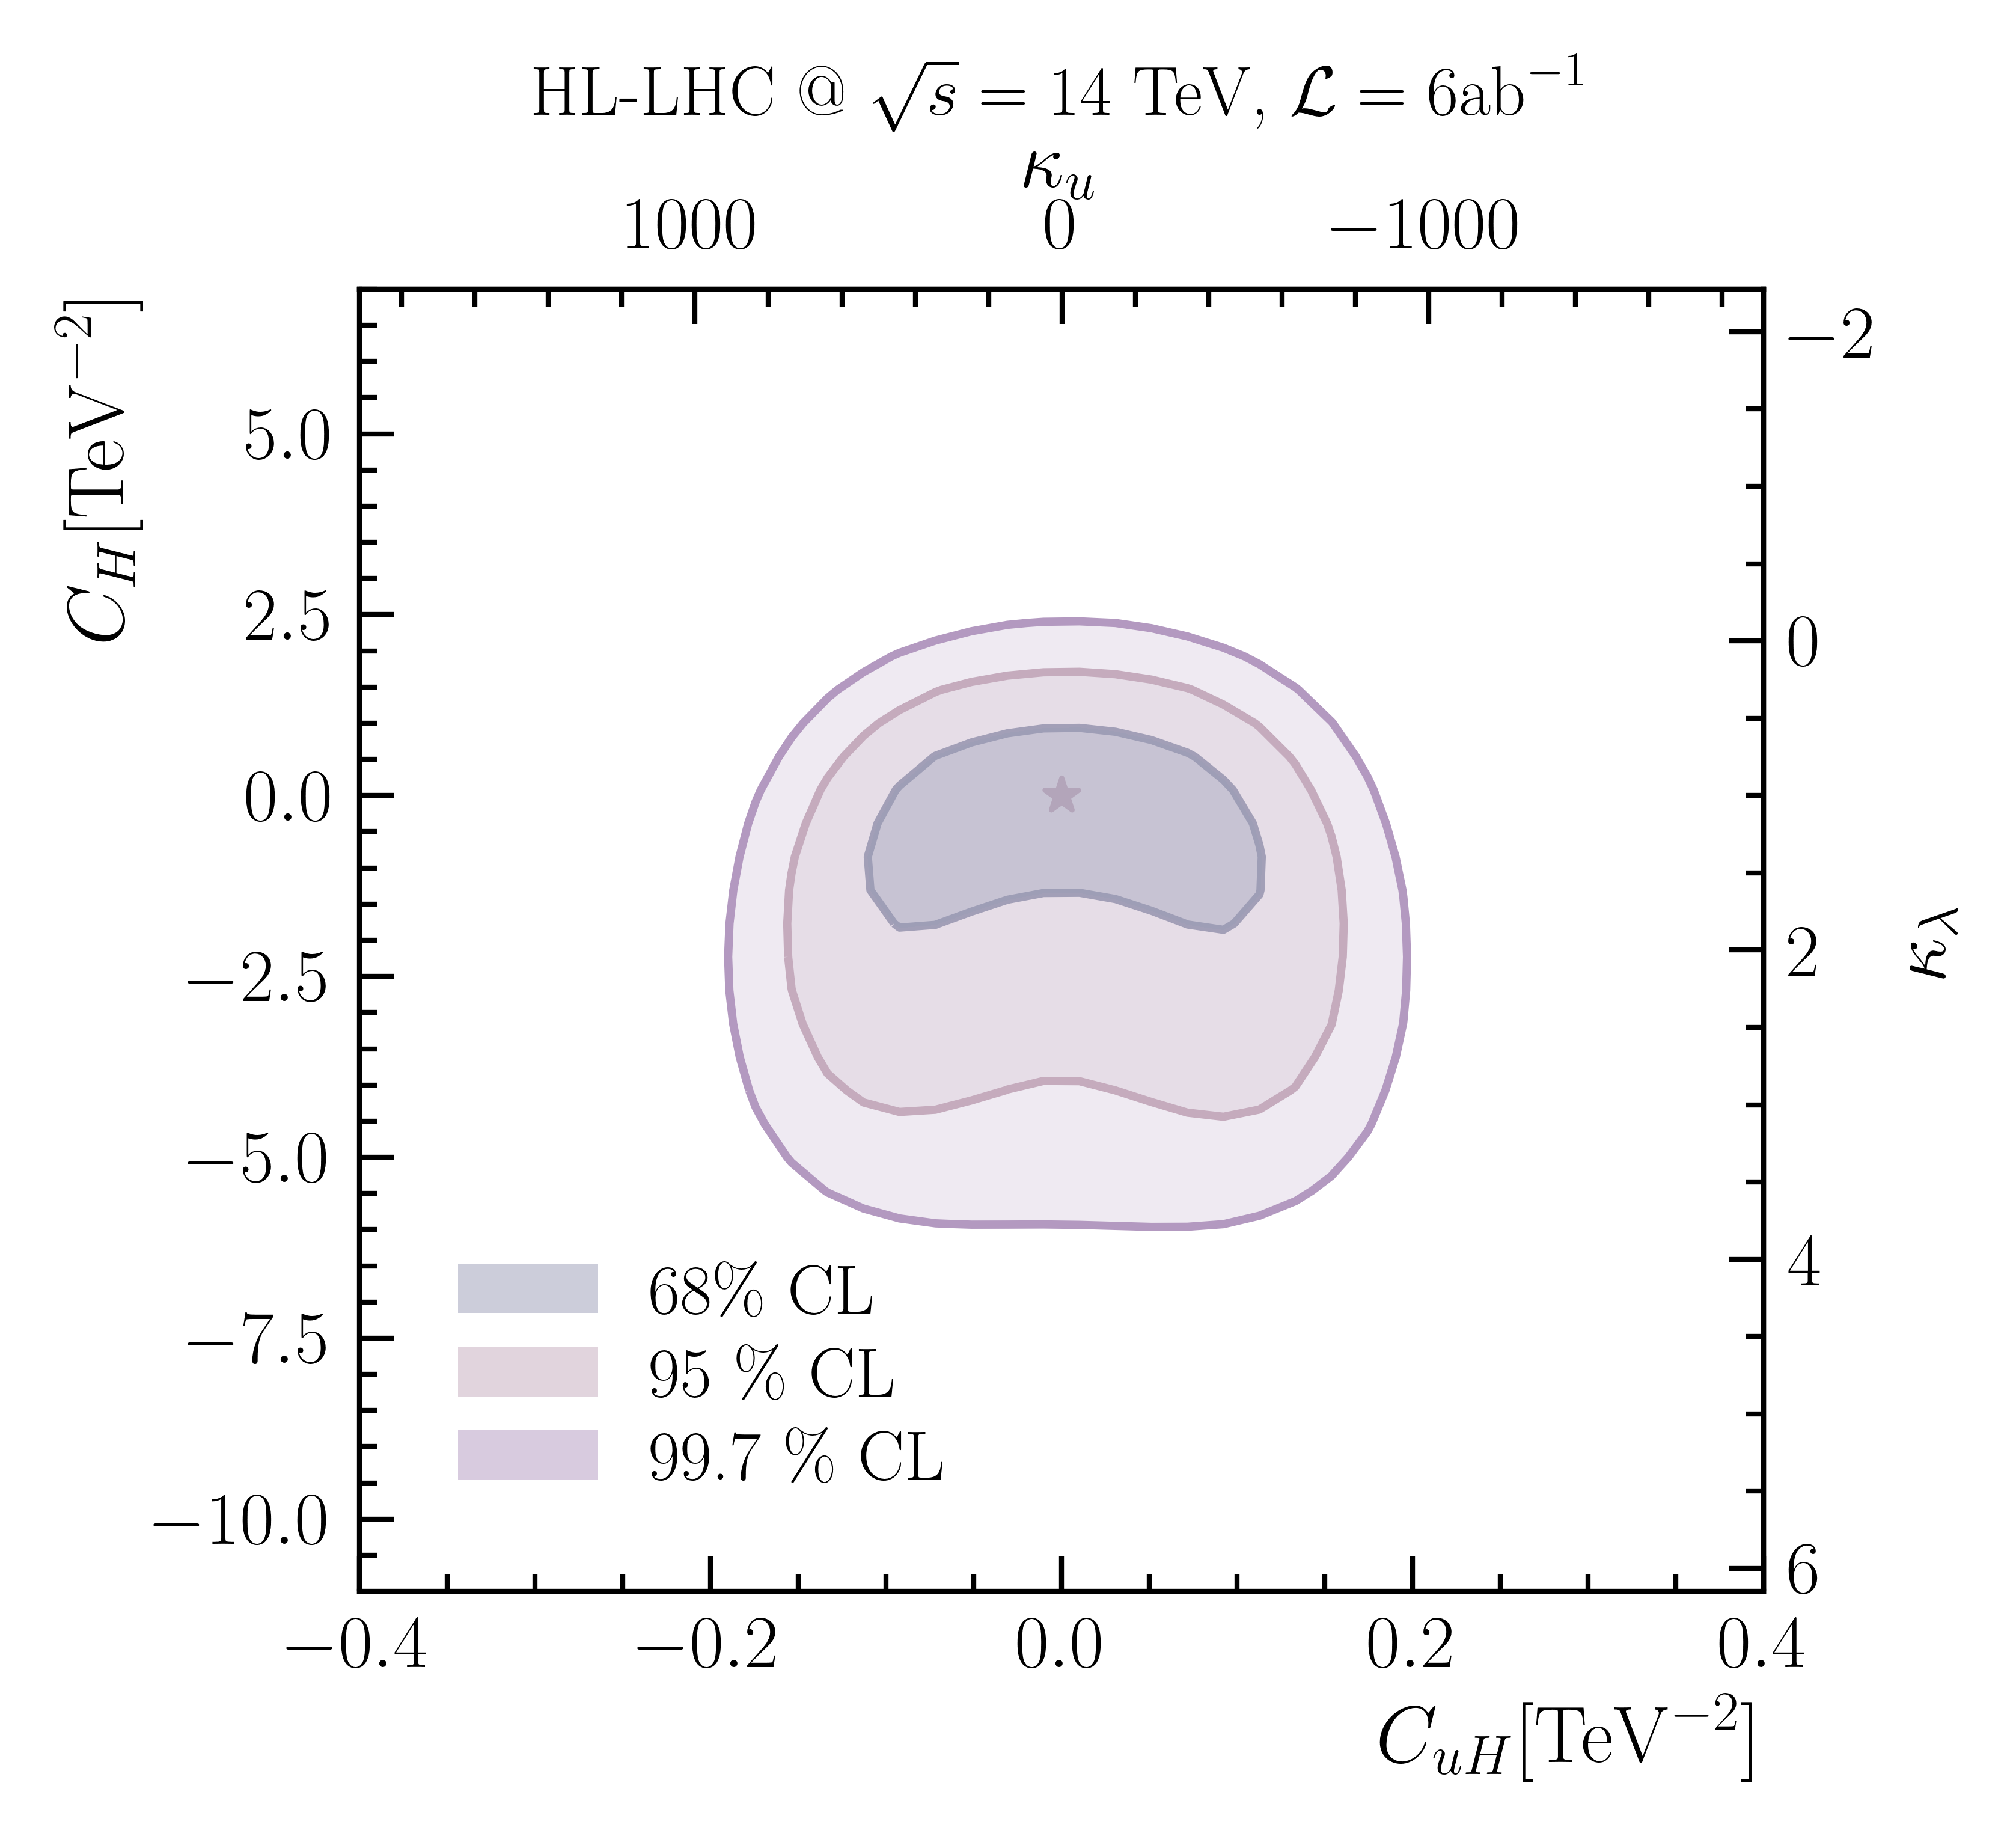

In [7]:

plt.style.use(hep.style.LHCb2)
fig, ax = plt.subplots(1, figsize=(11, 10))
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,       # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off)
)
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=True,         # ticks along the bottom edge are off
    right=False,       # ticks along the top edge are off)
)


proxy = [plt.Rectangle((0,0),1,1,fc =col[0+pc],alpha=0.5) 
    for pc in range(3)]

plt.legend(proxy, [r"68\% CL", "95 \% CL","99.7 \% CL"],loc=3)

ax.set_xlabel(r"$C_{uH} [\mathrm{TeV}^{-2}]$")
ax.set_ylabel(r"$C_H [\mathrm{TeV}^{-2}]$")
plt.contourf(grid_x,grid_y,int_obs,levels=[0.0,1.0],colors=col[0],alpha=0.4,zorder=4)
plt.contour(grid_x,grid_y,int_obs,levels=[1.0],colors=col[0])

plt.contourf(grid_x,grid_y,int_obs,levels=[0.0,4.0],colors=col[1],alpha=0.2,zorder=2)
plt.contour(grid_x,grid_y,int_obs,levels=[4.0],colors=col[1])

plt.contourf(grid_x,grid_y,int_obs,levels=[0.0,9.0],colors=col[2],alpha=0.2,zorder=1)
plt.contour(grid_x,grid_y,int_obs,levels=[9.0],colors=col[2])
def xinverse(x):
    return kqtoCqH(x,'ku')

def xforward(x):
    return CqHtokq(x,'ku')
secax = ax.secondary_xaxis('top', functions=(xforward, xinverse))
secax.xaxis.set_minor_locator(AutoMinorLocator())
secax.set_xlabel(r"$\kappa_u$")

secay = ax.secondary_yaxis('right', functions=(CHtokl, kltoCH))
secay.yaxis.set_minor_locator(AutoMinorLocator())
secay.set_ylabel(r"$\kappa_\lambda$")

ax.scatter(0.0, 0.0, s=200, marker='*',color=col[1])
plt.title(r"HL-LHC @ $\sqrt{s}=%d$ TeV, $\mathcal L= 6 \mathrm{ab}^{-1}$"%(14))
plt.gcf().tight_layout()
fig.savefig('../plots/kukl-HL-LHC.pdf', dpi=300)
plt.show()

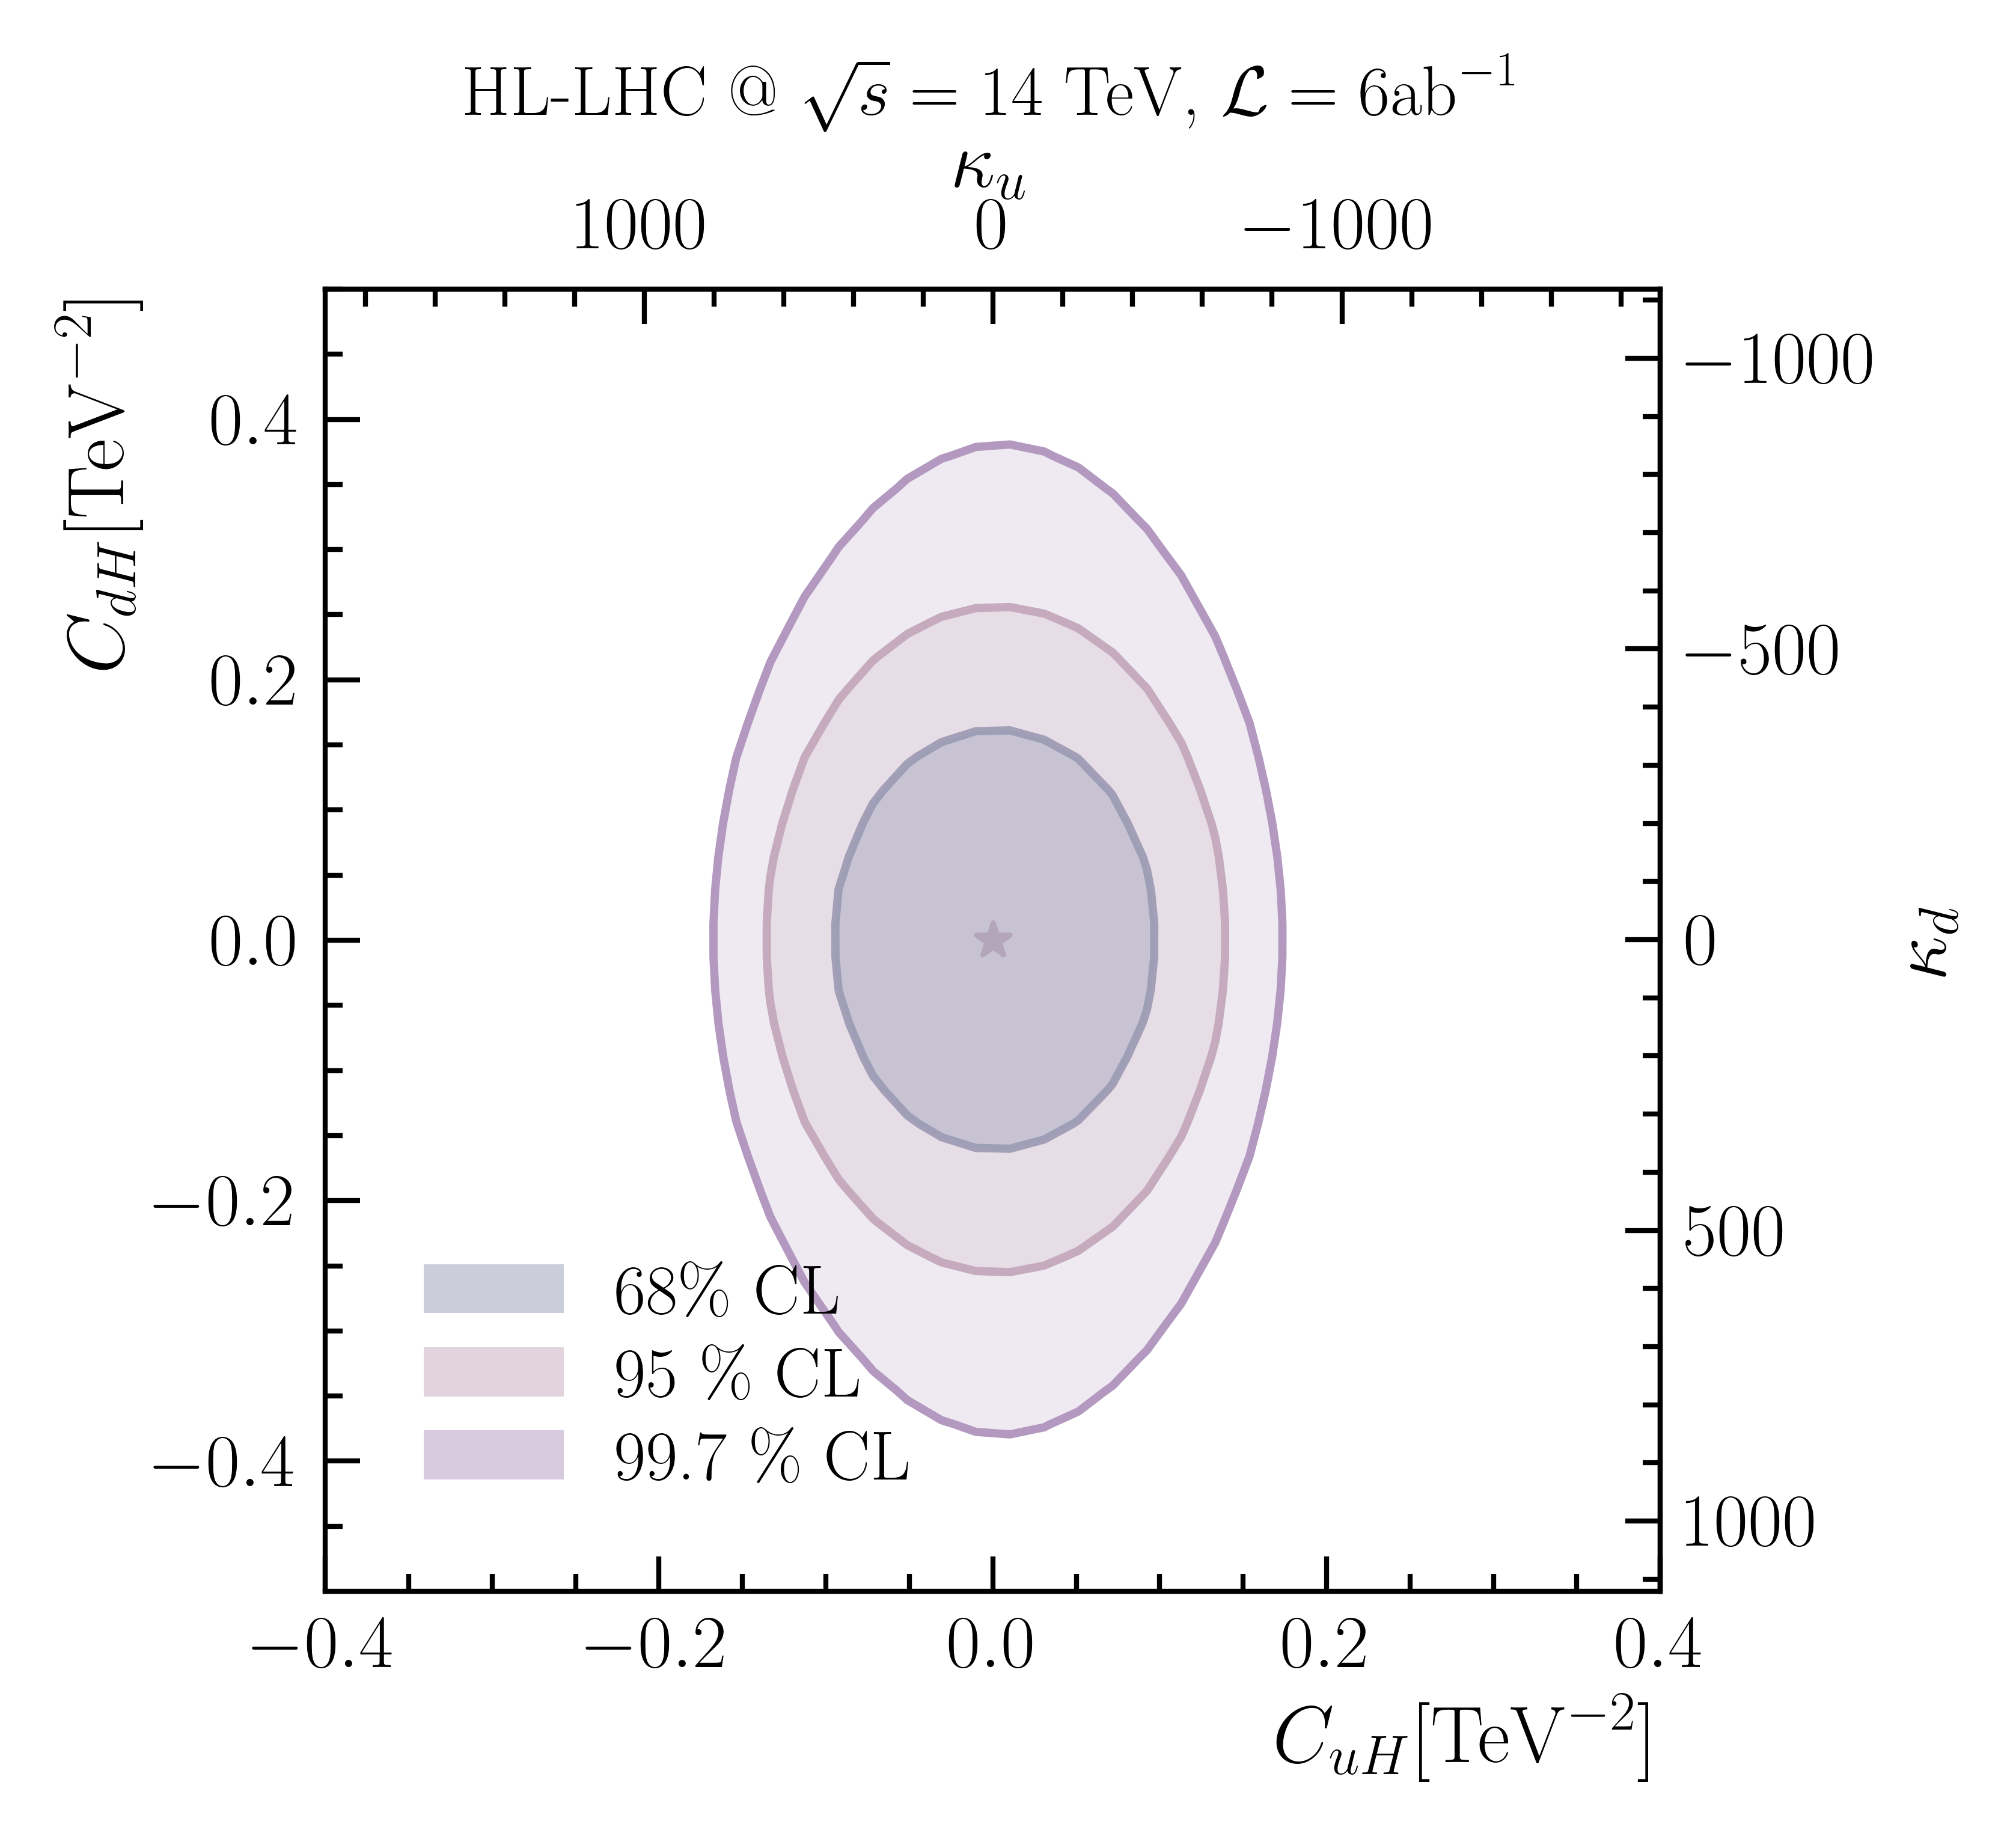

In [8]:
########################
nx, ny = 40, 40
CuHmin, CuHmax =  -0.4,0.4
CdHmin, CdHmax =  -0.5,0.5
########################
grid = grid_x, grid_y = np.mgrid[
    CuHmin: CuHmax:   complex(0, nx), CdHmin : CdHmax :  complex(0, ny)
]
X = grid.T.reshape(nx * ny, 2)
results = [CLs(cqh, ch,'kukd') for cqh, ch in X]

X = np.array([x for x, (_,  success) in zip(X, results) if success])
yobs = np.array([obs for obs,  success in results if success]).flatten()
int_obs = griddata(X, yobs, (grid_x, grid_y), method='linear')



plt.style.use(hep.style.LHCb2)
fig, ax = plt.subplots(1, figsize=(11, 10))
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,       # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off)
)
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=True,         # ticks along the bottom edge are off
    right=False,       # ticks along the top edge are off)
)


proxy = [plt.Rectangle((0,0),1,1,fc =col[0+pc],alpha=0.5) 
    for pc in range(3)]

plt.legend(proxy, [r"68\% CL", "95 \% CL","99.7 \% CL"],loc=3)

ax.set_xlabel(r"$C_{uH} [\mathrm{TeV}^{-2}]$")
ax.set_ylabel(r"$C_{dH} [\mathrm{TeV}^{-2}]$")
plt.contourf(grid_x,grid_y,int_obs,levels=[0.0,1.0],colors=col[0],alpha=0.4,zorder=4)
plt.contour(grid_x,grid_y,int_obs,levels=[1.0],colors=col[0])

plt.contourf(grid_x,grid_y,int_obs,levels=[0.0,4.0],colors=col[1],alpha=0.2,zorder=2)
plt.contour(grid_x,grid_y,int_obs,levels=[4.0],colors=col[1])

plt.contourf(grid_x,grid_y,int_obs,levels=[0.0,9.0],colors=col[2],alpha=0.2,zorder=1)
plt.contour(grid_x,grid_y,int_obs,levels=[9.0],colors=col[2])
def xinverse(x):
    return kqtoCqH(x,'ku')

def xforward(x):
    return CqHtokq(x,'ku')

def xinverse2(x):
    return kqtoCqH(x,'kd')

def xforward2(x):
    return CqHtokq(x,'kd')

secax = ax.secondary_xaxis('top', functions=(xforward, xinverse))
secax.xaxis.set_minor_locator(AutoMinorLocator())
secax.set_xlabel(r"$\kappa_u$")

secay = ax.secondary_yaxis('right', functions=(xforward2, xinverse2))
secay.yaxis.set_minor_locator(AutoMinorLocator())
secay.set_ylabel(r"$\kappa_d$")

#plt.grid(ls=':',color='#808080')
ax.scatter(0.0, 0.0, s=200, marker='*',color=col[1])
plt.title(r"HL-LHC @ $\sqrt{s}=%d$ TeV, $\mathcal L= 6 \mathrm{ab}^{-1}$"%(14))
plt.gcf().tight_layout()
fig.savefig('../plots/kdku-HL-LHC.pdf', dpi=300)
plt.show()
